In [3]:
import numpy as np
import pandas as pd 
from keras.preprocessing.image import ImageDataGenerator, load_img

import os
import random
import matplotlib.pyplot as plt

# initialize parameters
EPOCHS = 50
IMAGE_SIZE = (128, 128)
CHANNELS = 3
TRAIN_FOLDER = 'train'
TEST_FOLDER = 'test1'

In [4]:
filenames = os.listdir(TRAIN_FOLDER)

train_set = {}

# load images and labels

for file in filenames:
    if file[:3] == 'cat':
        train_set[file] = 'cat'
    else:
        train_set[file] = 'dog'

train_set = pd.DataFrame(train_set.items(), columns=['filename', 'label'])
print(train_set.sample(frac=1).head())


            filename label
13533  dog.10927.jpg   dog
20489   dog.5939.jpg   dog
19649   dog.5182.jpg   dog
24719   dog.9746.jpg   dog
1380   cat.11239.jpg   cat


In [5]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

# Build CNN

cnn = Sequential()

# Convolution + Pooling

cnn.add(Conv2D(32, (3,3), activation='relu', input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], CHANNELS)))
cnn.add(MaxPooling2D(pool_size=(2, 2)))

cnn.add(Conv2D(64, (3,3), activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2, 2)))

cnn.add(Conv2D(128, (3,3), activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2, 2)))

# Flattening

cnn.add(Flatten())

# NN

cnn.add(Dense(512, activation='relu'))
cnn.add(Dense(2, activation='softmax'))

cnn.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

cnn.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 128)      0

In [6]:
from keras.callbacks import EarlyStopping

# turn on early stopping
earlystop = EarlyStopping(patience=10)
callbacks = [earlystop]

In [7]:
from sklearn.model_selection import train_test_split

# split data into train and test sets
train, validate = train_test_split(train_set, test_size=0.20, random_state=42)
train = train.reset_index(drop=True)
validate = validate.reset_index(drop=True)

In [8]:
# create generators to transform and load images
rescale = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

generator = rescale.flow_from_dataframe(
    train, 
    "train/", 
    x_col='filename',
    y_col='label',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=16
)

validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate, 
    "train", 
    x_col='filename',
    y_col='label',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=16
)

Found 20000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.


In [9]:
total_train = train.shape[0]
total_validate = validate.shape[0]
batch_size = 16

# generate cnn and train

history = cnn.fit_generator(
    generator, 
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

Epoch 1/50


C:\Users\rushi\AppData\Local\Temp\ipykernel_35232\1210287814.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = cnn.fit_generator(


1250/1250 [==============================] - 300s 239ms/step - loss: 0.6365 - accuracy: 0.6486 - val_loss: 0.5296 - val_accuracy: 0.7374
Epoch 2/50
1250/1250 [==============================] - 289s 231ms/step - loss: 0.5468 - accuracy: 0.7304 - val_loss: 0.4601 - val_accuracy: 0.7794
Epoch 3/50
1250/1250 [==============================] - 290s 232ms/step - loss: 0.5125 - accuracy: 0.7549 - val_loss: 0.4411 - val_accuracy: 0.8007
Epoch 4/50
1250/1250 [==============================] - 290s 232ms/step - loss: 0.4893 - accuracy: 0.7722 - val_loss: 0.4371 - val_accuracy: 0.8055
Epoch 5/50
1250/1250 [==============================] - 277s 221ms/step - loss: 0.4721 - accuracy: 0.7836 - val_loss: 0.5153 - val_accuracy: 0.7348
Epoch 6/50
1250/1250 [==============================] - 277s 222ms/step - loss: 0.4611 - accuracy: 0.7901 - val_loss: 0.3957 - val_accuracy: 0.8145
Epoch 7/50
1250/1250 [==============================] - 277s 222ms/step - loss: 0.4496 - accuracy: 0.8013 - val_loss: 0.689

In [10]:

# save model and weights
cnn.save("cnn.h5")
cnn.save_weights("weights.h5")

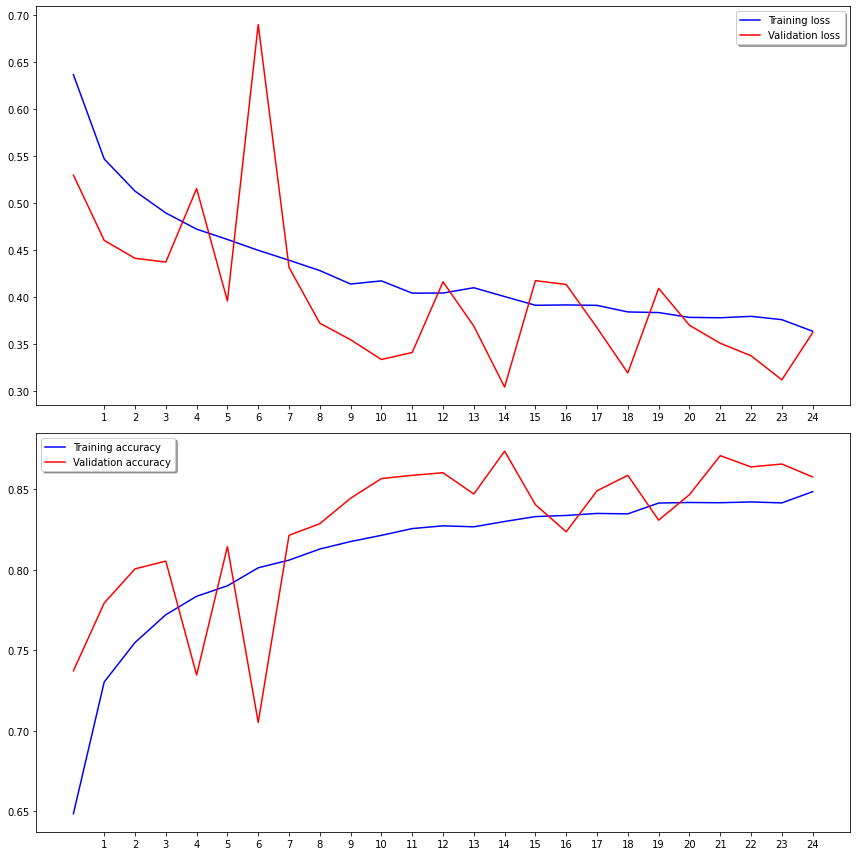

In [23]:
# plot data
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="Validation loss")
ax1.set_xticks(np.arange(1, 25, 1))
ax1.legend(loc='best', shadow=True)

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, 25, 1))
ax2.legend(loc='best', shadow=True)

plt.tight_layout()
plt.show()